# Exercise: Undercomplete Autoencoder with Convolutional Layers

In this exercise, we will implement an undercomplete autoencoder using convolutional layers. We will use the MNIST dataset, which consists of 28x28 grayscale images of handwritten digits.

# Includes and initialization

In [ ]:
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt

if torch.backends.cuda.is_built():
    device = torch.device('cuda')
elif torch.backends.mps.is_built():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Using device:', device)

mnist_train = MNIST('./data', download=True, transform=ToTensor())
mnist_test = MNIST('./data', download=True, train=False, transform=ToTensor())


mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=True)

Using device: cuda


# Exercise description

Objective of this exercise is to develop an undercomplete autoencoder, gain an apreciation for how well the reconstruction is and visualize how the examples are distributed in the embedding space.

The autoencoder will be based on a convolutional architecture with the following specs:

## Encoder Layers:

- encoder1: Convolutional layer with 1 input channel, 16 output channels, a kernel size of 3, stride of 2, and padding of 1. Relu activation.
- encoder2: Convolutional layer with 16 input channels, 32 output channels, a kernel size of 3, stride of 2, and padding of 1. Relu activation.
- encoder3: Convolutional layer with 32 input channels, 64 output channels, a kernel size of 7, stride of 1, and no padding. Relu activation.
- encoder4: Fully connected (linear) layer reducing the dimensionality to z_size. **No activation**.

## Decoder Layers:

- decoder1: Fully connected (linear) layer increasing the dimensionality from z_size to 64. Relu activation.
- decoder2: Transposed convolutional layer with 64 input channels, 32 output channels, a kernel size of 7, stride of 1, and no padding. Relu activation.
- decoder3: Transposed convolutional layer with 32 input channels, 16 output channels, a kernel size of 3, stride of 2, padding of 1, and output padding of 1. Relu activation.
- decoder4: Transposed convolutional layer with 16 input channels, 1 output channel, a kernel size of 3, stride of 2, padding of 1, and output padding of 1. Relu activation.

where z_size is a parameter of the model specifying the size of the embedding space.

## Usefull links

- Image with the [autoencoder architecture](https://datacloud.di.unito.it/index.php/s/PdbYrWrBPs2tnac)
- Link to a page explaining the [Transpose Convolution](https://d2l.ai/chapter_computer-vision/transposed-conv.html#fig-trans-conv)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, z_size=3):
        super(Model, self).__init__()
        self.z_size = z_size

        self.encoder1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.encoder2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.encoder3 = torch.nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0)
        self.encoder4 = torch.nn.Linear(64, z_size)

        self.decoder1 = torch.nn.Linear(z_size, 64)
        self.decoder2 = torch.nn.ConvTranspose2d(64, 32, kernel_size=7, stride=1, padding=0)
        self.decoder3 = torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder4 = torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        x = F.relu(self.encoder1(x))
        x = F.relu(self.encoder2(x))
        x = F.relu(self.encoder3(x))
        x = x.view(-1, 64)
        x = self.encoder4(x)

        return x

    def decode(self, z):
        z = F.relu(self.decoder1(z))
        z = z.view(-1, 64, 1, 1)
        z = F.relu(self.decoder2(z))
        z = F.relu(self.decoder3(z))
        z = F.relu(self.decoder4(z))

        return z

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def generate(self):
        x = torch.rand(1, self.z_size).to(device)
        x = self.decode(x)
        return x


In [ ]:
model = Model(z_size=20).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()

losses = []
tot_epochs=0

In [ ]:
def train_loop(model, tot_epochs, optimizer, loss_fn, losses, train_loader):
  epochs = 5
  for epoch in range(epochs):
      tot_epochs+=1
      train_loss = 0
      for i, (images, _) in enumerate(train_loader):
          images = images.to(device)
          outputs = model(images)

          loss = loss_fn(outputs, images)

          train_loss += loss.item()
          losses.append(loss.item())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, train_loss / len(train_loader)))

  print(f"Total epochs done so far: {tot_epochs}")

  return losses

losses = train_loop(model, tot_epochs, optimizer, loss_fn, losses, mnist_train_loader)


Epoch [1/5], Loss: 0.0678
Epoch [2/5], Loss: 0.0344
Epoch [3/5], Loss: 0.0253
Epoch [4/5], Loss: 0.0211
Epoch [5/5], Loss: 0.0185
Total epochs done so far: 5


In [ ]:
# torch.save(model.state_dict(), 'ae_model.pth')
# model.load_state_dict(torch.load('ae_model.pth'))

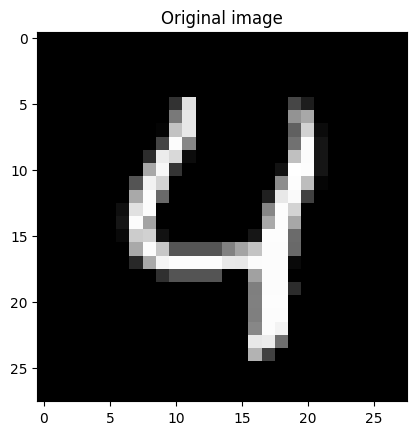

In [ ]:
img = mnist_test[4][0].numpy()
plt.imshow(img.reshape(28,28), cmap='gray')
plt.title("Original image")
plt.show()

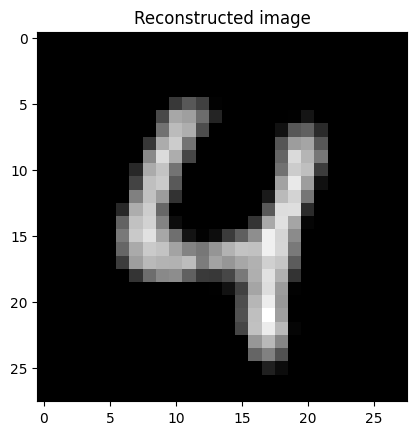

In [ ]:
img = model(mnist_test[4][0].to(device)).clip(0, 1).cpu().detach().numpy()
plt.imshow(img.reshape(28,28), cmap='gray')
plt.title("Reconstructed image")
plt.show()

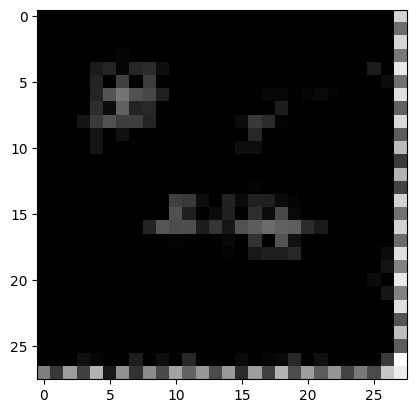

In [ ]:
gen = model.generate().clip(0, 1).cpu().detach().numpy().reshape(28,28)
plt.imshow(gen, cmap='gray')

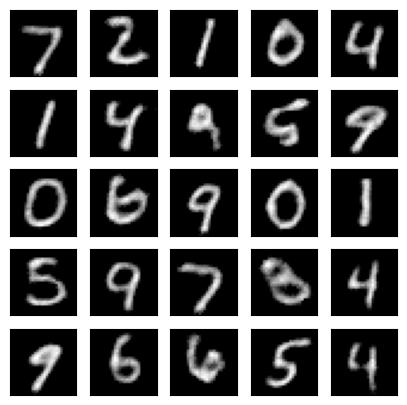

In [ ]:
plt.figure(figsize=(5,5))
plt.gray()

imshape=(28,28)
preds = []

for i in range(25):
    with torch.no_grad():
        preds.append(model(mnist_test[i][0].to(device)).cpu().float().numpy())

for i in range(25):
    ax = plt.subplot(5,5,i+1)
    ax.imshow(preds[i].reshape(imshape), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# EXTRA EXERCISES

In [ ]:
# Create a new model with latent space's dim = 3
model_1 = Model(z_size=3).to(device)

optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()

losses = []
tot_epochs=0

# Train model_1
loss = train_loop(model_1, tot_epochs, optimizer, loss_fn, losses, mnist_train_loader)

Epoch [1/5], Loss: 0.0627
Epoch [2/5], Loss: 0.0481
Epoch [3/5], Loss: 0.0459
Epoch [4/5], Loss: 0.0444
Epoch [5/5], Loss: 0.0432
Total epochs done so far: 5


In [ ]:
min_repr = np.array([1000, 1000, 1000])
max_repr = np.array([-1000, -1000, -1000])

for X, y in mnist_test_loader:
    X = X.to(device)

    with torch.no_grad():
        repr = model_1.encode(X)

        min_repr = np.minimum(min_repr, repr.min(dim=0)[0].cpu().numpy())
        max_repr = np.maximum(max_repr, repr.max(dim=0)[0].cpu().numpy())


print('min_repr:', min_repr)
print('max_repr:', max_repr)

min_repr: [-11.6160059  -15.81084728 -32.97041321]
max_repr: [35.0291748  28.39619064 21.12225533]


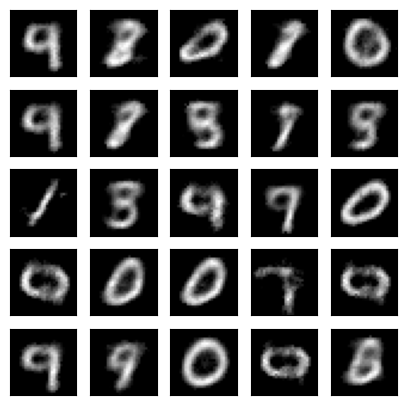

In [ ]:
# Generate random images form latent space
plt.figure(figsize=(5,5))
plt.gray()

imshape=(28,28)
preds = []

for i in range(25):
    with torch.no_grad():
        z1 = torch.rand(1, device=device) * (max_repr[0] - min_repr[0]) + min_repr[0]
        z2 = torch.rand(1, device=device) * (max_repr[1] - min_repr[1]) + min_repr[1]
        z3 = torch.rand(1, device=device) * (max_repr[2] - min_repr[2]) + min_repr[2]

        z = torch.cat([z1, z2, z3], dim=0).unsqueeze(0)
        preds.append(model_1.decode(z).cpu().float().numpy())


for i in range(25):
    ax = plt.subplot(5,5,i+1)
    # ax.imshow(preds[i].reshape(imshape))
    ax.imshow(preds[i].reshape(imshape), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
def plot_interpolations(img1, img2, nrows, ncols):
    img1 = mnist_train[img1][0]
    img2 = mnist_train[img2][0]

    mu1 = model_1.encode(img1.to(device))
    mu2 = model_1.encode(img2.to(device))

    preds = []

    num_steps = nrows * ncols

    for i in range(num_steps):
        z = mu1 + (mu2 - mu1) * (i / num_steps)
        with torch.no_grad():
            preds.append(model_1.decode(z).cpu().float().numpy())

    for i in range(num_steps):
        ax = plt.subplot(nrows,ncols,i+1)
        # ax.imshow(preds[i].reshape(imshape))
        ax.imshow(preds[i].reshape(imshape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

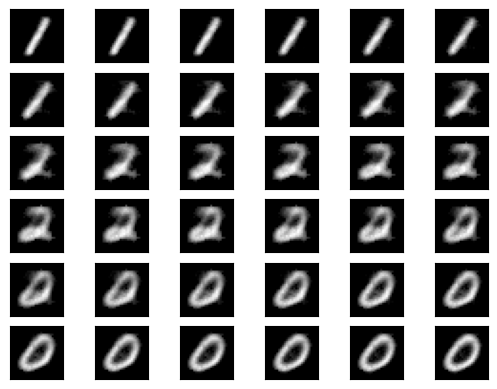

In [ ]:
# Make an interpolation (shifting from a class (image) to another classes)
plot_interpolations(3, 21, 6,6)

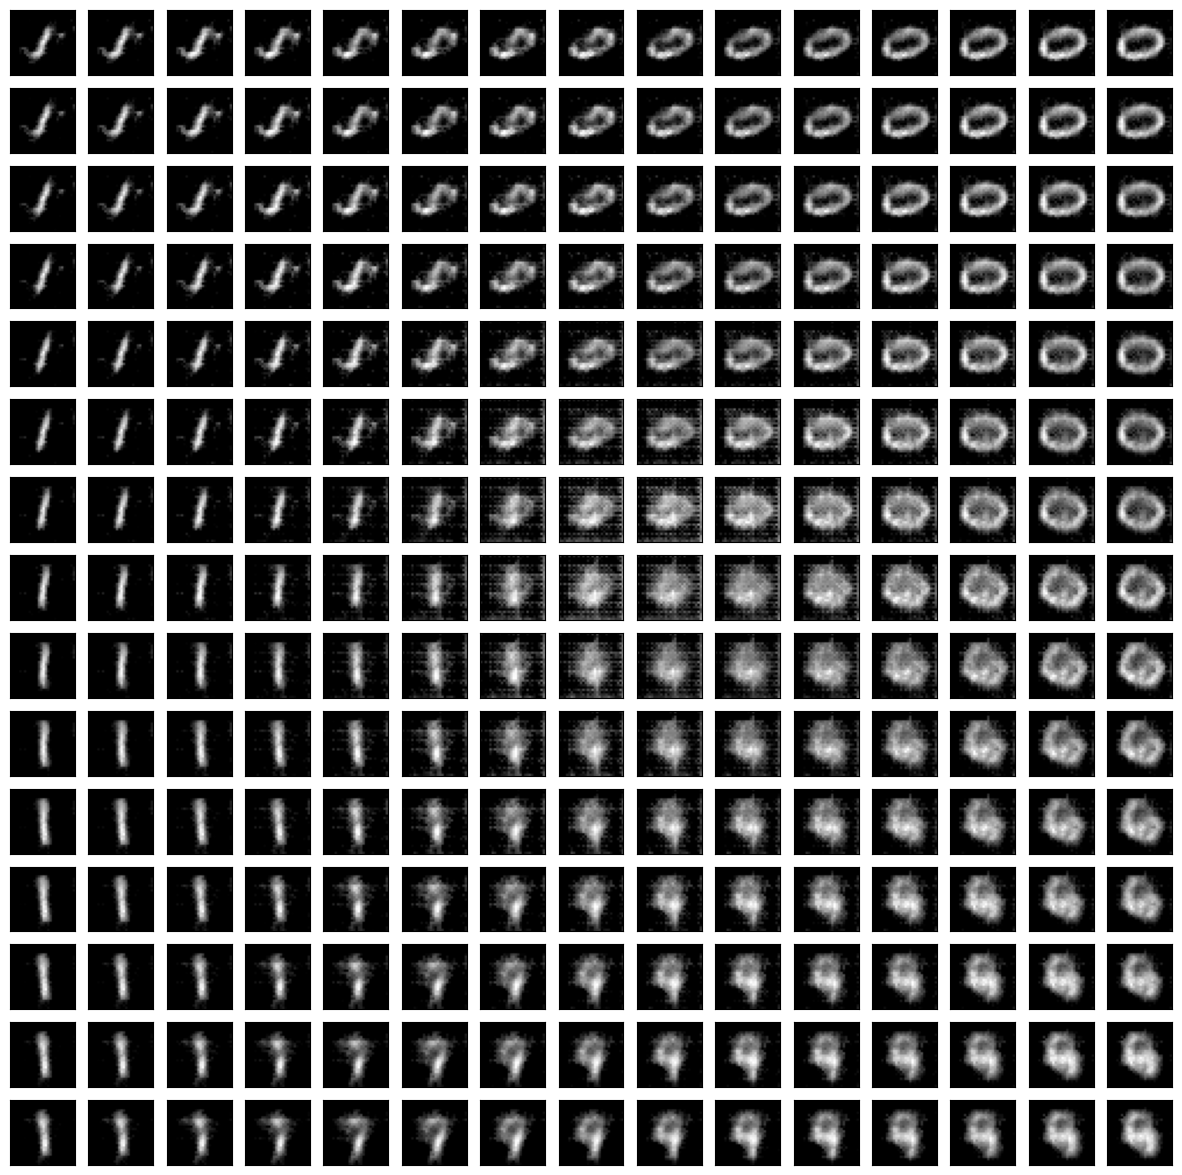

In [ ]:
def plot_interpolations2(nrows, ncols):
    preds = []

    colstep = 10 / (ncols - 1)
    rowstep = 10 / (nrows - 1)

    plt.figure(figsize=(ncols * 1, nrows * 1))

    for i in range(nrows):
        for j in range(ncols):
            z = torch.tensor([i * rowstep - 5, j * colstep - 5, 0.0]).to(device)
            img = model_1.decode(z).cpu().detach().float().numpy()
            ax = plt.subplot(nrows, ncols, i * ncols + j + 1)
            ax.imshow(img.reshape(imshape), cmap="gray")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()


plot_interpolations2(15, 15)

In [ ]:
# visualize the latent space by plotting the train dataset in 2D using tsne
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

def plot_latent_space(model, dataset_loader):
    z, labels = [], []
    for i, (batch, ys) in enumerate(dataset_loader):
        z_ = model_1.encode(batch.to(device))
        z.append(z_.cpu().detach().numpy())
        labels.append(ys.numpy())

        if i > 100:
            break

    z = np.concatenate(z, axis=0)
    labels = np.concatenate(labels, axis=0)

    # z_embedded = TSNE(n_components=2).fit_transform(z)
    z_embedded = z
    df = pd.DataFrame(np.concatenate([z_embedded, labels.reshape(-1,1)], axis=1), columns=["x", "y", "z", "label"])
    df["label"] = df["label"].astype(int).astype(str)

    # scatter plot 3d using plotly
    import plotly.express as px
    fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='label', category_orders={"label": [str(i) for i in range(10)]})
    fig.update_traces(marker_size = 3)

    fig.show()
    fig.write_html("ae-representations.html")


plot_latent_space(model_1, mnist_train_loader)